# Time Series Forecasting

## Bussines Understanding

Notebook ini bertujuan untuk memprediksi kualitas udara harian berdasarkan konsentrasi Nitrogen Dioksida (NO₂). NO₂ merupakan salah satu indikator utama pencemaran udara yang dihasilkan dari aktivitas transportasi, industri, dan pembakaran bahan bakar fosil. Kadar NO₂ yang tinggi dapat berdampak negatif terhadap kesehatan manusia serta kualitas lingkungan.

Melalui analisis ini, dilakukan pendekatan time series forecasting untuk menganalisis pola perubahan harian konsentrasi NO₂ selama periode 1 bulan pada tanggal 20-10-2023 sd 19-10-2025 di suatu daerah Kota Probolinggo. Tujuannya adalah untuk memprediksi kadar NO₂ pada tanggal 20-10-2025.

### Link Deploy
https://prediksi-no2-63m2susxdbqe7gols3gu6t.streamlit.app/

## Data Understanding

Dataset yang digunakan adalah dataset citra satelit (NO₂) yang diambil melalui platform [Dataspace Copernicus](https://dataspace.copernicus.eu/). Dokumentasi pengambilan data NO₂ dapat diakses melalui link berikut: [Dokumentasi](https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NO2Covid.html). Pengambilan titik koordinat suatu daerah dapat menggunakan platform [geojson](https://geojson.io/#map=12.3/-7.0356/112.74145). Pada Notebook ini, digunakan kordinat poligon dari suatu daerah di Kota Bangkalan yang dapat dilihat pada gambar di bawah ini:

![Grafik NO2](../images/citra.png "Grafik Hasil Interpolasi")

## Mengambil Data

Berikut adalah kode yang digunakan untuk mengambil data berdasarkan kordinat poligon yang sudah didapatkan:

In [2]:
import openeo
from shapely.geometry import shape

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

aoi = {
    "type": "Polygon",
    "coordinates": [
          [
            [
              112.72,
              -7.00
            ],
            [
              112.72,
              -7.05
            ],
            [
              112.77,
              -7.05
            ],
            [
              112.77,
              -7.00
            ],
            [
              112.72,
              -7.00
            ]
          ]
    ],
}

prob = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-01-20", "2025-10-20"],
    spatial_extent={
        "west":112.72,
        "south":-7.05,
        "east":112.77,
        "north":-7.00
    },
    bands=["NO2"],
)

feature = {"type":"Feature", "geometry": aoi, "properties": {"id": 1}}

fc = {"type": "FeatureCollection", "features": [feature]}
# Now aggregate by day to avoid having multiple data per day
prob = prob.aggregate_temporal_period(reducer="mean", period="day")

# let's create a spatial aggregation to generate mean timeseries data
prob = prob.aggregate_spatial(reducer="mean", geometries=fc)

job = prob.execute_batch(title="NO2 Kota Bangkalan Jnr 2025 - Okt 2025", outputfile="no2BARU.nc")

Authenticated using refresh token.
0:00:00 Job 'j-2511021947114fa4ae2128f49c3177d1': send 'start'
0:00:14 Job 'j-2511021947114fa4ae2128f49c3177d1': created (progress 0%)
0:00:19 Job 'j-2511021947114fa4ae2128f49c3177d1': created (progress 0%)
0:00:26 Job 'j-2511021947114fa4ae2128f49c3177d1': created (progress 0%)
0:00:34 Job 'j-2511021947114fa4ae2128f49c3177d1': created (progress 0%)
0:00:47 Job 'j-2511021947114fa4ae2128f49c3177d1': created (progress 0%)
0:00:59 Job 'j-2511021947114fa4ae2128f49c3177d1': running (progress N/A)
0:01:15 Job 'j-2511021947114fa4ae2128f49c3177d1': running (progress N/A)
0:01:34 Job 'j-2511021947114fa4ae2128f49c3177d1': running (progress N/A)
0:01:58 Job 'j-2511021947114fa4ae2128f49c3177d1': running (progress N/A)
0:02:28 Job 'j-2511021947114fa4ae2128f49c3177d1': running (progress N/A)
0:03:06 Job 'j-2511021947114fa4ae2128f49c3177d1': finished (progress 100%)


### Convert to CSV
Dataset yang dihasilkan berupa file NetCDF (.nc). Untuk mempermudah pemrosesan data kita perlu konversi menjadi format dataset umum seperti (.csv). Berikut adalah kode yang dapat digunakan untuk mengonversi file (.nc) ke (.csv):

In [3]:
import xarray as xr
# open dataset NetCDF
ds = xr.open_dataset("/workspaces/PSD1/Tugas/data/no2.nc")

# lihat isi untuk menyesuaikan transformasi
print(ds)

df = ds.to_dataframe().reset_index()

# Ambil kolom waktu dan NO2
df = df[['t', 'NO2']]

# Simpan ke CSV
df.to_csv("/workspaces/PSD1/Tugas/data/NO2.csv", index=False)

<xarray.Dataset> Size: 5kB
Dimensions:        (t: 305, feature: 1)
Coordinates:
  * t              (t) datetime64[ns] 2kB 2023-10-20 2023-10-21 ... 2025-10-19
    lat            (feature) float64 8B ...
    lon            (feature) float64 8B ...
    feature_names  (feature) int64 8B ...
Dimensions without coordinates: feature
Data variables:
    NO2            (feature, t) float64 2kB ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.


### Exploratory Data Analysis (EDA)
Setelah berhasil mendapatkan data dalam bentuk (.csv), langkah selanjutnya adalah melihat/mengeksplor kondisi data:



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
no2_asli = pd.read_csv('/workspaces/PSD1/Tugas/data/NO2.csv')
no2_asli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       305 non-null    object 
 1   NO2     305 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


In [5]:
# Ubah kolom 'date' menjadi tipe datetime
no2_asli['date'] = pd.to_datetime(no2_asli['t'])
no2_asli.info()

no2 = no2_asli.copy()
no2 = no2.drop(columns=['t'])   # kolom 't' dihapus karena sudah redundant

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('date')

# Set kolom 'date' sebagai index datetime
no2 = no2.set_index('date')
print(no2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       305 non-null    object        
 1   NO2     305 non-null    float64       
 2   date    305 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.3+ KB
                 NO2
date                
2023-10-20  0.000027
2023-10-21  0.000040
2023-10-22  0.000036
2023-10-24  0.000038
2023-10-25  0.000026


In [6]:
# MEMERIKSA MISSING DATES

# Cek rentang tanggal lengkap (harian)
tanggal_lengkap = pd.date_range(start=no2.index.min(), end=no2.index.max(), freq='D')

print(tanggal_lengkap)

# Cari tanggal yang hilang
tanggal_hilang = tanggal_lengkap.difference(no2.index)

print("Tanggal yang hilang:\n", tanggal_hilang)

DatetimeIndex(['2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23',
               '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
               '2023-10-28', '2023-10-29',
               ...
               '2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-19'],
              dtype='datetime64[ns]', length=731, freq='D')
Tanggal yang hilang:
 DatetimeIndex(['2023-10-23', '2023-10-28', '2023-11-03', '2023-11-04',
               '2023-11-11', '2023-11-13', '2023-11-21', '2023-11-23',
               '2023-11-24', '2023-11-25',
               ...
               '2025-10-01', '2025-10-05', '2025-10-06', '2025-10-11',
               '2025-10-12', '2025-10-13', '2025-10-15', '2025-10-16',
               '2025-10-17', '2025-10-18'],
              dtype='datetime64[ns]', length=426, freq=None)


Hasil ekstraksi data menunjukkan bahwa periode waktu yang dicakup adalah 20 Oktober 2023 hingga 19 Oktober 2025 sebanyak 731 hari. Namun, terdapat 426 hari yang tidak memiliki nilai pengamatan NO₂.

Untuk memastikan data dapat dipakai dalam pemodelan time series, dilakukan proses interpolasi agar data menjadi kontinu/hariannya lengkap dan siap digunakan pada tahap pembelajaran mesin (supervised learning).

## Pre-Processing

Tahap ini akan melakukan proses awal data untuk menangani missing dates yang sudah ditemukan pada tahap Data Understanding serta mengubah data Time Series menjadi data Supervied.

### Menangani Missing Value

Dates yang hilang akan ditambahkan dan value NO2 pada dates baru akan diisi menggunakan teknik Interpolasi linear.

In [7]:
# Reindex dataframe agar semua tanggal muncul
no2 = no2.reindex(tanggal_lengkap)
print(no2.head(10))

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Reset index dan ubah nama kolom index ke 'date' kembali
no2 = no2.reset_index().rename(columns={'index': 'date'})

# Cek hasil
# print(no2.head())
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

                 NO2
2023-10-20  0.000027
2023-10-21  0.000040
2023-10-22  0.000036
2023-10-23       NaN
2023-10-24  0.000038
2023-10-25  0.000026
2023-10-26  0.000066
2023-10-27  0.000048
2023-10-28       NaN
2023-10-29  0.000052

Jumlah missing value setelah interpolasi:
date    0
NO2     0
dtype: int64


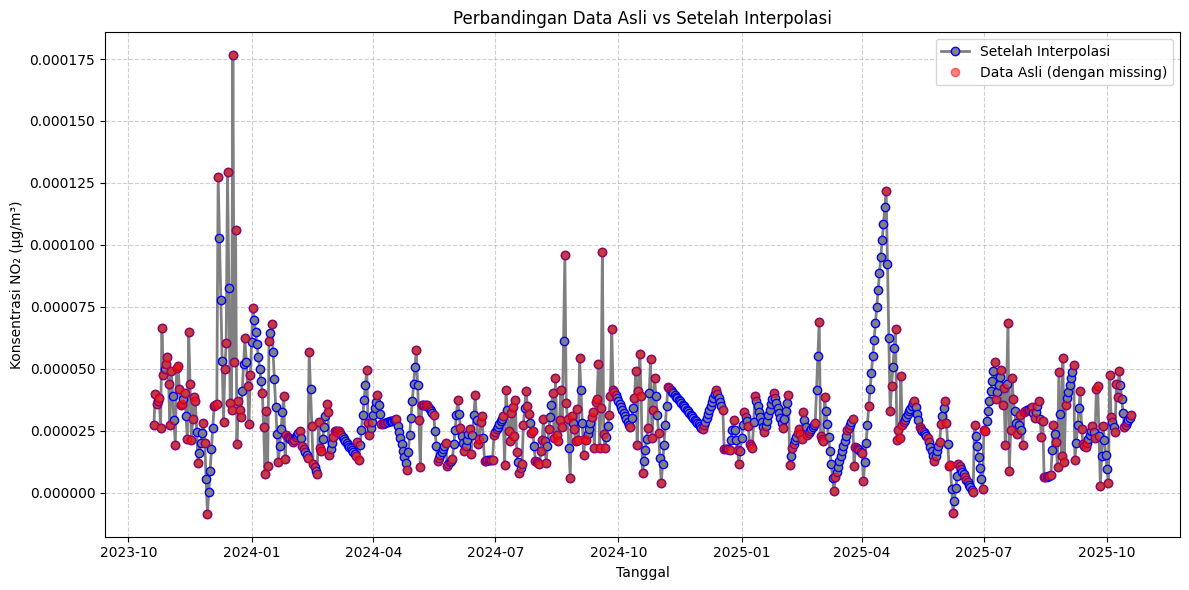

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], linestyle='-', color='grey', linewidth=2,  marker='o', markeredgecolor='blue', label='Setelah Interpolasi')
plt.plot(no2_asli['date'], no2_asli['NO2'], 'ro', alpha=0.5, label='Data Asli (dengan missing)')
plt.title('Perbandingan Data Asli vs Setelah Interpolasi')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Grafik menunjukkan perbandingan antara data NO₂ asli dan hasil interpolasi. Titik merah menandakan data asli yang masih memiliki nilai hilang, sedangkan garis biru adalah data yang sudah dilengkapi melalui interpolasi. Dengan interpolasi, tren konsentrasi NO₂ menjadi lebih jelas dan data siap digunakan untuk analisis lanjutan.

### Mengubah Data menjadi Supervised

Pada tahap ini, data time series yang sudah lengkap akan diubah menjadi data supervised menggunakan teknik sliding windows. Teknik ini sederhananya memanfaatkan data masa lalu menjadi fitur/input. Misalnya kita akan memanfaatkan hari kemarin (t-2), hari ini (t-1) sebagai fitur untuk memprediksi hari esok (t). Data masa lalu atau disebut sebagai lag ukurannya bisa menyesuaikan dengan data masing-masing untuk mendapat akurasi terbaik. Pada eksperimen yang saya lakukan, ukuran terbaiknya adalah 4, jadi pada notebook ini data supervised memanfaatkan 4 hari masa lalu untuk memprediksi hari berikutnya.

In [19]:
supervised = pd.DataFrame()
supervised['t-7'] = no2['NO2'].shift(7)
supervised['t-6'] = no2['NO2'].shift(6)
supervised['t-5'] = no2['NO2'].shift(5)
supervised['t-4'] = no2['NO2'].shift(4)
supervised['t-3'] = no2['NO2'].shift(3)
supervised['t-2'] = no2['NO2'].shift(2)
supervised['t-1'] = no2['NO2'].shift(1)
supervised['t'] = no2['NO2']
supervised = supervised.dropna().reset_index(drop=True)
print(supervised.head())

        t-7       t-6       t-5       t-4       t-3       t-2       t-1  \
0  0.000027  0.000040  0.000036  0.000037  0.000038  0.000026  0.000066   
1  0.000040  0.000036  0.000037  0.000038  0.000026  0.000066  0.000048   
2  0.000036  0.000037  0.000038  0.000026  0.000066  0.000048  0.000050   
3  0.000037  0.000038  0.000026  0.000066  0.000048  0.000050  0.000052   
4  0.000038  0.000026  0.000066  0.000048  0.000050  0.000052  0.000055   

          t  
0  0.000048  
1  0.000050  
2  0.000052  
3  0.000055  
4  0.000044  


### Normalisasi Data
Pada tahap ini data supervised yang sudah dihasilkan akan dinormalisasi menggunakan teknik MinMaxScaler. MinMaxScaler akan mengubah fitur (kolom data) dengan menskalakan setiap nilai dalam rentang tertentu, biasanya antara 0 dan 1. Pada notebook ini, range yang akan digunakan antara 0 dan 1. Jadi nilai minimum fitur asli akan menjadi 0, dan nilai maksimum fitur asli akan menjadi 1.

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_values = scaler.fit_transform(supervised)
scaled = pd.DataFrame(scaled_values, columns=supervised.columns)

print(scaled.head())

        t-7       t-6       t-5       t-4       t-3       t-2       t-1  \
0  0.192739  0.261334  0.239436  0.246245  0.253054  0.187869  0.404131   
1  0.261334  0.239436  0.246245  0.253054  0.187869  0.404131  0.303341   
2  0.239436  0.246245  0.253054  0.187869  0.404131  0.303341  0.315465   
3  0.246245  0.253054  0.187869  0.404131  0.303341  0.315465  0.327589   
4  0.253054  0.187869  0.404131  0.303341  0.315465  0.327589  0.342970   

          t  
0  0.303341  
1  0.315465  
2  0.327589  
3  0.342970  
4  0.283016  


## Modeling
Pada tahap ini, kita akan menggunakan model KNN Regressor yang disediakan oleh library Sklearn untuk training dan testing data. Selanjutkan kita akan ukur akurasi model menggunakan Mean Squared Error (MSE) dan R^2.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [28]:
# ============================================
# ✂️ Split data
# ============================================
X = scaled.drop('t', axis=1)
y = scaled['t']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ============================================
# 🌲 Model Random Forest
# ============================================
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2
)
rf.fit(X_train, y_train)

# ============================================
# 📊 Evaluasi pada data uji
# ============================================
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("📊 Evaluasi Model Random Forest (Data Uji)")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")
print(f"MAPE : {mape:.2f}%")


📊 Evaluasi Model Random Forest (Data Uji)
RMSE : 0.062183
R²   : 0.365437
MAPE : 79.17%


Evaluasi Hasil Model

- Mean Squared Error (MSE) = 0.0065
Nilai ini menunjukkan rata-rata besar kesalahan prediksi model terhadap data aktual. Semakin kecil nilainya semakin baik, sehingga model cukup baik dalam meminimalkan error.

- R² Score = 0.4540
Nilai ini berarti sekitar 45,40% variasi data dapat dijelaskan oleh model. Artinya, model sudah mampu menangkap pola sebagian data, namun masih bisa ditingkatkan agar lebih akurat (misalnya tuning parameter atau menggunakan fitur tambahan).

In [29]:
result = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\nContoh hasil prediksi:")
print(result.head())


Contoh hasil prediksi:
     Actual  Predicted
0  0.147212   0.151469
1  0.157621   0.153152
2  0.196694   0.161976
3  0.213246   0.218093
4  0.229799   0.202301


Dari hasil training model yang sudah dilakukan, berikut adalah hasil prediksi untuk tanggal 20-10-2025:



/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor wa


🔮 Prediksi Konsentrasi NO₂ untuk 7 Hari ke Depan:
Hari ke-1: 0.0000288722 µg/m³
Hari ke-2: 0.0000277017 µg/m³
Hari ke-3: 0.0000273609 µg/m³
Hari ke-4: 0.0000282967 µg/m³
Hari ke-5: 0.0000288585 µg/m³
Hari ke-6: 0.0000283792 µg/m³
Hari ke-7: 0.0000283124 µg/m³


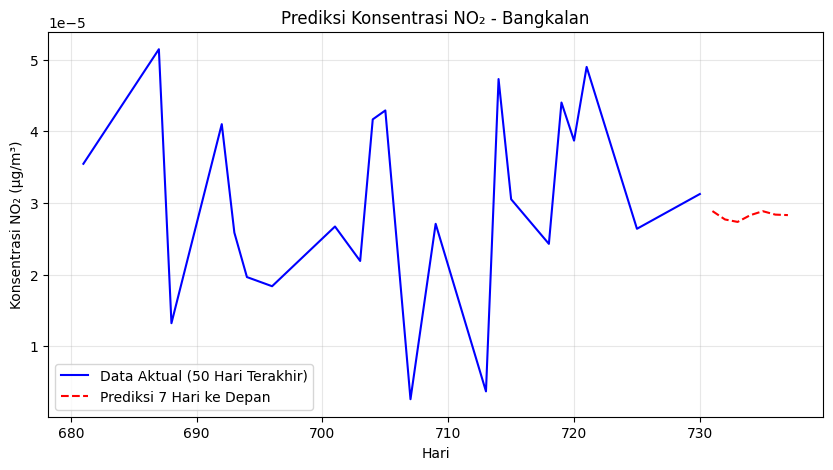

In [33]:
# ============================================
# 🔮 Prediksi 7 Hari ke Depan
# ============================================
last_known = scaled.iloc[-1][:-1].values  # ambil 7 nilai terakhir (t-7..t-1)
future_preds_scaled = []

current_input = last_known.copy()

for i in range(7):
    next_pred = rf.predict(current_input.reshape(1, -1))[0]
    future_preds_scaled.append(next_pred)
    # Geser window: buang nilai terlama dan tambahkan prediksi baru
    current_input = np.roll(current_input, -1)
    current_input[-1] = next_pred

# Balikkan skala ke nilai asli
# Ambil kolom terakhir (t) dari scaler untuk inverse transform
dummy = np.zeros((len(future_preds_scaled), scaled.shape[1]))
dummy[:, -1] = future_preds_scaled
future_preds_original = scaler.inverse_transform(dummy)[:, -1]

print("\n🔮 Prediksi Konsentrasi NO₂ untuk 7 Hari ke Depan:")
for i, val in enumerate(future_preds_original, start=1):
    print(f"Hari ke-{i}: {val:.10f} µg/m³")

# ============================================
# 📈 Visualisasi Prediksi
# ============================================
plt.figure(figsize=(10,5))
plt.plot(no2.index[-50:], no2['NO2'].values[-50:], label="Data Aktual (50 Hari Terakhir)", color='blue')
plt.plot(range(len(no2), len(no2)+7), future_preds_original, 'r--', label="Prediksi 7 Hari ke Depan")
plt.title("Prediksi Konsentrasi NO₂ - Bangkalan")
plt.xlabel("Hari")
plt.ylabel("Konsentrasi NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()